In [222]:
import numpy as np
from pathlib import Path

DATASET_FOLDER = Path('./mnist')
class_labels = ['top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [225]:
# Function for one-hot encoding
def one_hot_encoding(label_data):
    row_number = label_data.shape[0]
    num_labels = 10  # MNIST dataset (0-9)
    encoded_labels = np.zeros((row_number, num_labels), dtype='int')
    encoded_labels[list(range(row_number)), label_data] = 1
    return encoded_labels

# Function to read pixel data from the dataset
def read_pixels(data_path):
    with open(data_path, 'rb') as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    flattened_pixels = pixel_data.reshape(-1, 784)
    normalized_pixels = flattened_pixels / 255
    return normalized_pixels

# Function to read label data from the dataset
def read_labels(data_path):
    with open(data_path, 'rb') as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    one_hot_encoding_labels = one_hot_encoding(label_data)
    return one_hot_encoding_labels

# Function to read the entire dataset
def read_dataset(path):
    X_train = read_pixels(path/"train-images-idx3-ubyte")
    y_train = read_labels(path/"train-labels-idx1-ubyte")
    X_test = read_pixels(path/"t10k-images-idx3-ubyte")
    y_test = read_labels(path/"t10k-labels-idx1-ubyte")
    return X_train, y_train, X_test, y_test

def split_val(X_train, y_train):
    return X_train[10000:], y_train[10000:], X_train[:10000], y_train[:10000]

def z(X, W):
    W0 = W[:,0]
    W = W[:,1:]
    return W0 + X @ W.T

def softmax(Z):
    # Z -= np.max(Z, axis=1, keepdims=True)
    expZ = np.exp(Z)
    return expZ / expZ.sum(axis=1, keepdims=True)

def predict(X, W):
    Z = z(X, W)
    return softmax(Z)

def predict_class(X, W):
    return np.argmax(predict(X,W), axis=-1)

def cross_entropy_loss(Y, T):
    return -(np.log(Y) * T).sum() / T.shape[0]

def regularization_loss(W, l2):
    return l2 / 2 * np.linalg.norm(W[:,1:], 2)

def calculate_loss(Y, T, W, l2):
    ce_loss = cross_entropy_loss(Y, T)
    l2_loss = regularization_loss(W, l2)
    return ce_loss + l2_loss

def grad(X, Y, T, W, l2):
    X = np.hstack((np.ones(shape=(X.shape[0],1)), X))
    L_derivative = Y - T
    l2_grad = l2 * W
    return L_derivative.T @ X + l2_grad

def new_weights(X, Y, T, W, lr, l2):
    return W - lr * grad(X, Y, T, W, l2)

def confusion_matrix(labels, predictions, size):
    cm = np.zeros((size,size)).astype(np.int32)
    for i in range(len(labels)):
        cm[labels[i]][predictions[i]] += 1
    return cm

In [ ]:
X_train, y_train, X_test, y_test = read_dataset(DATASET_FOLDER)
X_train, y_train, X_val, y_val = split_val(X_train, y_train)
label_train, label_val, label_test = [np.argmax(_, axis=-1) for _ in [y_train, y_val, y_test]]
print(*[_.shape for _ in [X_train, y_train, X_val, y_val, X_test, y_test]])

In [ ]:
weights = np.random.normal(0,1,(10,785))
lr = 5 * (10 ** (-4))
l2 = 10 ** (-4)
batch_size = 200
epochs = 100

In [ ]:
for epoch in range(epochs):
    batch_count = int(X_train.shape[0] / batch_size)
    loss = 0
    for batch in range(batch_count):
        X = X_train[batch*batch_size:(batch+1)*batch_size]
        T = y_train[batch*batch_size:(batch+1)*batch_size]
        Y = predict(X, weights)
        loss += calculate_loss(Y, T, weights, l2)
        weights = new_weights(X, Y, T, weights, lr, l2)
    loss /= batch_count
    print(f"Epoch {epoch+1}/{epochs}, loss = {loss:.6f}")

In [226]:
prediction_test = predict_class(X_test, weights)
cm=confusion_matrix(label_test, prediction_test, y_test.shape[1])

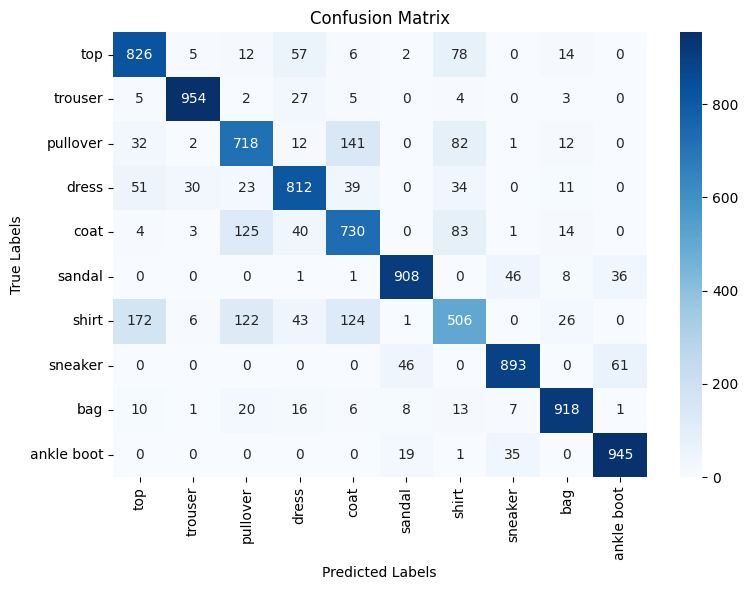

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns

title='Confusion Matrix'
cmap='Blues'
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
            xticklabels=class_labels, yticklabels=class_labels)

plt.title(title)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()